#pm2.5

In [18]:
import tensorflow as tf
from tensorflow.keras.models import Model
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras import optimizers
from pandas import Series
import math
import numpy
from tensorflow.keras.layers import *
from tensorflow.keras import layers
import pandas as pd

data = pd.read_csv("https://raw.githubusercontent.com/ikwak2/hj19_timeseries/main/bike_pm2.5/PRSA_data_2010.1.1-2014.12.31.csv?token=ATB7FVYSDM5VD6QOACJUTLDBMQKUE")

In [2]:
def gradient_importance(seq, model):

    seq = tf.Variable(seq[np.newaxis,:,:], dtype=tf.float32)

    with tf.GradientTape() as tape:
        predictions = model(seq)

    grads = tape.gradient(predictions, seq)
    grads = tf.reduce_mean(grads, axis=1).numpy()[0]
    
    return grads

def gradient_weight(seq, model):

    seq = tf.Variable(seq[np.newaxis,:,:], dtype=tf.float32)

    with tf.GradientTape() as tape:
        predictions = model(seq)

    grad = tape.gradient(predictions, seq)
    #gr=grads
    #grads = tf.reduce_mean(grads, axis=1).numpy()[0]
    
    return grad


def activation_grad(seq, model):
    
    seq = seq[np.newaxis,:,:]
    grad_model = Model([model.inputs], 
                       [model.get_layer('extractor').output, 
                        model.output])

    # Obtain the predicted value and the intermediate filters
    with tf.GradientTape() as tape:
        seq_outputs, predictions = grad_model(seq)

    # Extract filters and gradients
    output = seq_outputs[0]
    grads = tape.gradient(predictions, seq_outputs)[0]

    # Average gradients spatially
    weights = tf.reduce_mean(grads, axis=0)
    
    # Get a ponderated map of filters according to grad importance
    cam = np.ones(output.shape[0], dtype=np.float32)
    for index, w in enumerate(weights):
        cam += w * output[:, index]

    time = int(seq.shape[1]/output.shape[0])
    cam = zoom(cam.numpy(), time, order=1)
    heatmap = (cam - cam.min())/(cam.max() - cam.min())
    
    return heatmap

In [3]:
data['pm2.5'] = data['pm2.5'].fillna(method='ffill').fillna(method='bfill')

In [4]:

data['cbwd']=data['cbwd'].factorize()[0]

In [5]:
data.columns[5:]

Index(['pm2.5', 'DEWP', 'TEMP', 'PRES', 'cbwd', 'Iws', 'Is', 'Ir'], dtype='object')

In [6]:

from sklearn.preprocessing import MinMaxScaler
values = data[data.columns[5:]].values.reshape(-1,8)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled=scaler.fit_transform(values)
#caled = (values-(np.min(values)))/(np.max(values)-(np.min(values)))
#scaled = (values - np.mean(values))/np.std(values) 

In [7]:
np.max(values)

1046.0

In [8]:
np.min(values)

-40.0

In [9]:
np.max(values)-np.min(values)

1086.0

In [10]:
'''
from sklearn.preprocessing import MinMaxScaler
values = data[data.columns[5:]].values.reshape(-1,8)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled=scaler.fit_transform(values)
'''

"\nfrom sklearn.preprocessing import MinMaxScaler\nvalues = data[data.columns[5:]].values.reshape(-1,8)\nvalues = values.astype('float32')\nscaler = MinMaxScaler(feature_range=(0, 1))\nscaled=scaler.fit_transform(values)\n"

In [11]:
train_size = int(len(scaled) * 0.80)
val_size = int(len(scaled) * 0.10)

test_size = len(scaled) - train_size-val_size
train,val, test,test1 = scaled[0:train_size,:],scaled[train_size:train_size+val_size,:], scaled[train_size+val_size:,:],scaled[train_size:,]
print(len(train),len(val), len(test),len(test1))

35059 4382 4383 8765


In [12]:

def create_dataset_multistep(dataset, look_back=1,predict=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back-predict):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i+ look_back: i+ look_back+predict, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [13]:
look_back = 168
predict=24

trainX, trainY = create_dataset_multistep(train, look_back,predict)
valX, valY = create_dataset_multistep(val, look_back,predict)
testX, testY = create_dataset_multistep(test, look_back,predict)

34867
4190
4191


In [14]:
print(trainX.shape)
print(trainY.shape)

(34867, 168, 8)
(34867, 24)


cnn-lstm

In [15]:
first_input = Input(shape=(168,8))

in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(first_input)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)
in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)

in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)

#in1= BatchNormalization(scale=False)(in1)

#in1=add([in0,in1],name='extractor')
#attn_layer25 = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
in1=MaxPooling1D(pool_size=2, name='extractor')(in1)
#in1=Dropout(0.5)(in1)
#in1=Flatten()(in1)
#in1=Dense(100, activation='relu')(in1)
in1=LSTM(100)(in1)
in1=Dense(100)(in1)
in1=Dropout(0.5)(in1)
out=Dense(24)(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')

checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/ff/saved_weights/pm2.5_1dcnn-lstm_multi3.hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

#history=model.fit(trainX, trainY, epochs=20, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

Epoch 1/20
349/349 [==============================] - ETA: 0s - loss: 0.0060
Epoch 00001: val_loss improved from inf to 0.00544, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/ff/saved_weights\pm2.5_1dcnn-lstm_multi3.hdf5
349/349 [==============================] - 40s 114ms/step - loss: 0.0060 - val_loss: 0.0054
Epoch 2/20
349/349 [==============================] - ETA: 0s - loss: 0.0051
Epoch 00002: val_loss improved from 0.00544 to 0.00504, saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/ff/saved_weights\pm2.5_1dcnn-lstm_multi3.hdf5
349/349 [==============================] - 38s 108ms/step - loss: 0.0051 - val_loss: 0.0050
Epoch 3/20
349/349 [==============================] - ETA: 0s - loss: 0.0048
Epoch 00003: val_loss did not improve from 0.00504
349/349 [==============================] - 38s 109ms/step - loss: 0.0048 - val_loss: 0.0053
Epoch 4/20
349/349 [==============================] - ETA: 0s - loss: 0.0046
Epoch 00004: val_loss improved from 0.0

In [16]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/ff/saved_weights/pm2.5_1dcnn-lstm_multi3.hdf5")

[0.4528521  0.5306867  0.60852903 0.6267509  0.6442561  0.6244917
 0.6038158  0.58677804 0.5698883  0.4087113  0.24024244 0.24628004
 0.26351255 0.318895   0.37725338 0.35448185 0.32423925 0.33480313
 0.3497141  0.36266965 0.3753759  0.38196662 0.3877082  0.41440612
 0.44429815 0.44122872 0.43258908 0.4397641  0.44987613 0.44709495
 0.44169614 0.41636154 0.38662532 0.35794082 0.3295134  0.3279631
 0.33333853 0.3622022  0.39757872 0.42935604 0.46007386 0.44208565
 0.4086256  0.45744845 0.5341456  0.6103598  0.68639475 0.7204936
 0.73852074 0.7189355  0.68407315 0.58577305 0.4601284  0.4403172
 0.4687836  0.42513362 0.34669918 0.34041226 0.37084183 0.43031427
 0.5053832  0.522569   0.50698805 0.50056094 0.49958712 0.51215315
 0.53321075 0.6087082  0.7201353  0.7438494  0.70672005 0.6476371
 0.5725526  0.52508533 0.49875352 0.5041913  0.53518176 0.55324006
 0.5603761  0.61953694 0.7248251  0.79782176 0.8407784  0.9012636
 0.97884107 1.         0.9633381  0.8715352  0.7204469  0.6301164
 0

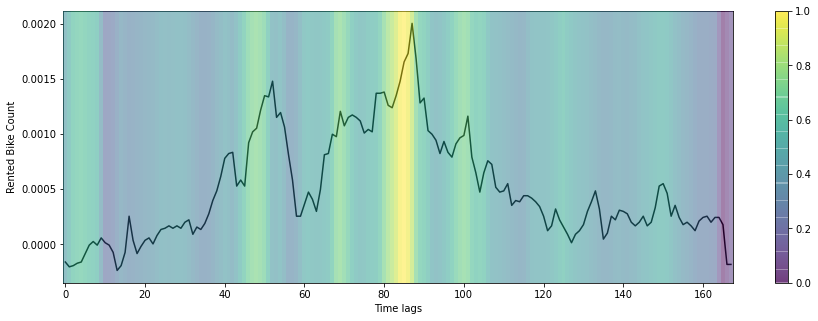

In [19]:
from scipy.ndimage import zoom
import random
import pylab

X_test=testX.copy()
id_=24*12
testX_inverse=X_test[id_][:,0]*(np.max(values)-np.min(values))+np.min(values)
testX_inverse

X_test=testX.copy()
activation = activation_grad(X_test[id_], model)
print(activation)
plt.figure(figsize=(15,5))

plt.plot(testX_inverse/100000, 'k')
#plt.plot(yhat, label='predict')
#plt.plot(testY, label='true')
plt.ylabel('PM2.5'); plt.xlabel('Time lags'); #plt.title(pd.to_datetime(test_date[sequence_length+id_]))
plt.twinx()
#plt.xticks(a)
plt.imshow(np.vstack([activation]*120), alpha=0.5, cmap='viridis')
plt.axis('off'); plt.colorbar()
plt.axis('off')
#pylab.pcolor(np.vstack([activation]*120),cmap='jet',alpha=0.35)

#pylab.colorbar()

np.set_printoptions(False)

plt.savefig('C:/Users/mozzimerci/jupyter notebook/time/chan/ff/png/pm2.5_grad cam_cnn-lstm(1).png', dpi=300)

1.0
0.0
1.0
(1, 168, 8)


<Figure size 432x1440 with 0 Axes>

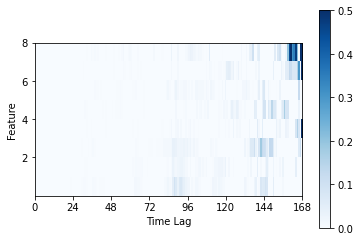

In [20]:
import matplotlib.pyplot as plt
import numpy as np

X_test=testX

grad_weight = gradient_weight(X_test[4], model)

grad_weight_abs = abs(grad_weight)

grad_weight_abs_z = (grad_weight_abs-(np.min(grad_weight_abs)))/(np.max(grad_weight_abs)-(np.min(grad_weight_abs)))

print(np.max(grad_weight_abs_z))
print(np.min(grad_weight_abs_z))
print(np.max(grad_weight_abs_z)-np.min(grad_weight_abs_z))
#grad_weight=grad_weight.reshape(48,4)

print(grad_weight.shape)
plt.figure(figsize=(6,20))

#plt.plot(X_test[8], 'k')
a=grad_weight.numpy()
a=a.reshape(168,8)
a=a.transpose()

#print(a)
fig, ax = plt.subplots(1,1)

extent = [0 , 168, 0 , 8]
y_label_list = [2,4,6,8]
x_label_list = [0,24,48,72,96,120,144,168]
ax.set_xticks([0,24,48,72,96,120,144,168])

ax.set_yticks([24,48,72,96])

ax.set_xticklabels(x_label_list)
ax.set_yticklabels(y_label_list)

ax.set_xticklabels(x_label_list)
ax.set_yticklabels(y_label_list)
ax.set_ylabel('Feature')
ax.set_xlabel('Time Lag')

plt.imshow(a,extent = [0 , 168, 0 , 96], vmin=0, vmax=0.5, cmap="Blues", interpolation='nearest')
plt.colorbar()

plt.savefig('C:/Users/mozzimerci/jupyter notebook/time/chan/ff/png/pm2.5_feature importance_cnn-lstm(1).png', dpi=300)

lstm-cnn

In [21]:
from tensorflow.keras.models import Model

first_input = Input(shape=(168,8))


in0=LSTM(64,return_sequences=True)(first_input)
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=add([in0,in1],name='extractor1')

#ad=Dropout(0.5)(ad)
#in0=LSTM(64,return_sequences=True)(ad)
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same',name='extractor')(in1)
#in1= BatchNormalization(scale=False)(in1)

#ad1=add([in0,in1])


#in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(ad1)
#in1= BatchNormalization(scale=False)(in0)

#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

#in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=add([ad1,in1],name='extractor2')
#in0=Conv1D(filters=64, kernel_size=5, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)

#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

#in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=add([in0,in1])

#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1]

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2, name='extractor')(in1)
in1=Flatten()(in1)

in1=Dense(100, activation='relu')(in1)
in1=Dropout(0.5)(in1)

out=Dense(24,'relu')(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')

checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/ff/saved_weights/pm2.5_lstmcnn_multi.hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=False,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)


#history=model.fit(trainX, trainY, epochs=100, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

Epoch 1/100
349/349 [==============================] - ETA: 0s - loss: 0.0072
Epoch 00001: saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/ff/saved_weights\pm2.5_lstmrescnn_multi.hdf5
349/349 [==============================] - 51s 146ms/step - loss: 0.0072 - val_loss: 0.0058
Epoch 2/100
349/349 [==============================] - ETA: 0s - loss: 0.0053
Epoch 00002: saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/ff/saved_weights\pm2.5_lstmrescnn_multi.hdf5
349/349 [==============================] - 51s 145ms/step - loss: 0.0053 - val_loss: 0.0052
Epoch 3/100
349/349 [==============================] - ETA: 0s - loss: 0.0049
Epoch 00003: saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/ff/saved_weights\pm2.5_lstmrescnn_multi.hdf5
349/349 [==============================] - 50s 143ms/step - loss: 0.0049 - val_loss: 0.0056
Epoch 4/100
349/349 [==============================] - ETA: 0s - loss: 0.0047
Epoch 00004: saving model to C:/Users/mozzimerci/

349/349 [==============================] - ETA: 0s - loss: 0.0021
Epoch 00029: saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/ff/saved_weights\pm2.5_lstmrescnn_multi.hdf5
349/349 [==============================] - 48s 139ms/step - loss: 0.0021 - val_loss: 0.0062
Epoch 30/100
349/349 [==============================] - ETA: 0s - loss: 0.0021
Epoch 00030: saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/ff/saved_weights\pm2.5_lstmrescnn_multi.hdf5
349/349 [==============================] - 49s 139ms/step - loss: 0.0021 - val_loss: 0.0064
Epoch 31/100
349/349 [==============================] - ETA: 0s - loss: 0.0021
Epoch 00031: saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/ff/saved_weights\pm2.5_lstmrescnn_multi.hdf5
349/349 [==============================] - 49s 140ms/step - loss: 0.0021 - val_loss: 0.0062
Epoch 32/100
349/349 [==============================] - ETA: 0s - loss: 0.0020
Epoch 00032: saving model to C:/Users/mozzimerci/jupyter n

349/349 [==============================] - ETA: 0s - loss: 0.0018
Epoch 00057: saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/ff/saved_weights\pm2.5_lstmrescnn_multi.hdf5
349/349 [==============================] - 49s 142ms/step - loss: 0.0018 - val_loss: 0.0062
Epoch 58/100
349/349 [==============================] - ETA: 0s - loss: 0.0018
Epoch 00058: saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/ff/saved_weights\pm2.5_lstmrescnn_multi.hdf5
349/349 [==============================] - 49s 141ms/step - loss: 0.0018 - val_loss: 0.0063
Epoch 59/100
349/349 [==============================] - ETA: 0s - loss: 0.0018
Epoch 00059: saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/ff/saved_weights\pm2.5_lstmrescnn_multi.hdf5
349/349 [==============================] - 49s 141ms/step - loss: 0.0018 - val_loss: 0.0064
Epoch 60/100
349/349 [==============================] - ETA: 0s - loss: 0.0017
Epoch 00060: saving model to C:/Users/mozzimerci/jupyter n

349/349 [==============================] - ETA: 0s - loss: 0.0016
Epoch 00085: saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/ff/saved_weights\pm2.5_lstmrescnn_multi.hdf5
349/349 [==============================] - 52s 150ms/step - loss: 0.0016 - val_loss: 0.0065
Epoch 86/100
349/349 [==============================] - ETA: 0s - loss: 0.0016
Epoch 00086: saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/ff/saved_weights\pm2.5_lstmrescnn_multi.hdf5
349/349 [==============================] - 53s 151ms/step - loss: 0.0016 - val_loss: 0.0065
Epoch 87/100
349/349 [==============================] - ETA: 0s - loss: 0.0016
Epoch 00087: saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/ff/saved_weights\pm2.5_lstmrescnn_multi.hdf5
349/349 [==============================] - 52s 149ms/step - loss: 0.0016 - val_loss: 0.0066
Epoch 88/100
349/349 [==============================] - ETA: 0s - loss: 0.0016
Epoch 00088: saving model to C:/Users/mozzimerci/jupyter n

In [23]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/ff/saved_weights/pm2.5_lstmcnn_multi.hdf5")

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]


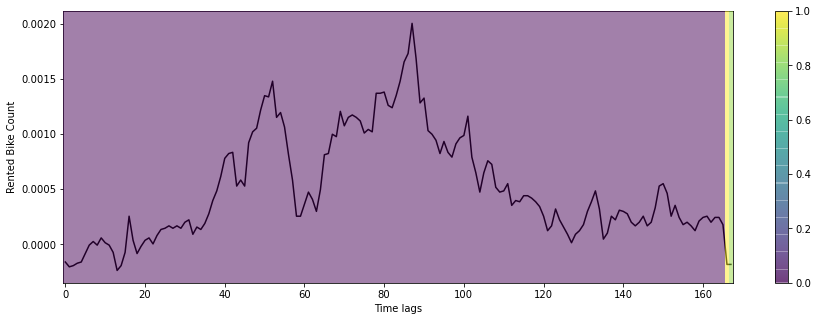

In [24]:
from scipy.ndimage import zoom
import random
import pylab

X_test=testX.copy()
id_=24*12
testX_inverse=X_test[id_][:,0]*(np.max(values)-np.min(values))+np.min(values)
testX_inverse

X_test=testX.copy()
activation = activation_grad(X_test[id_], model)
print(activation)
plt.figure(figsize=(15,5))

plt.plot(testX_inverse/100000, 'k')
#plt.plot(yhat, label='predict')
#plt.plot(testY, label='true')
plt.ylabel('PM2.5'); plt.xlabel('Time lags'); #plt.title(pd.to_datetime(test_date[sequence_length+id_]))
plt.twinx()
#plt.xticks(a)
plt.imshow(np.vstack([activation]*120), alpha=0.5, cmap='viridis')
plt.axis('off'); plt.colorbar()
plt.axis('off')
#pylab.pcolor(np.vstack([activation]*120),cmap='jet',alpha=0.35)

#pylab.colorbar()

np.set_printoptions(False)

plt.savefig('C:/Users/mozzimerci/jupyter notebook/time/chan/ff/png/pm2.5_grad cam_lstm-cnn(1).png', dpi=300)

1.0
0.0
1.0
(1, 168, 8)


<Figure size 432x1440 with 0 Axes>

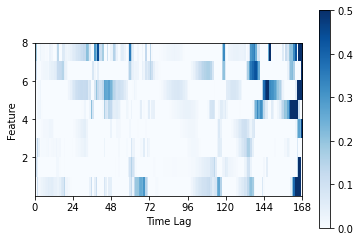

In [26]:
import matplotlib.pyplot as plt
import numpy as np

X_test=testX

grad_weight = gradient_weight(X_test[4], model)

grad_weight_abs = abs(grad_weight)

grad_weight_abs_z = (grad_weight_abs-(np.min(grad_weight_abs)))/(np.max(grad_weight_abs)-(np.min(grad_weight_abs)))

print(np.max(grad_weight_abs_z))
print(np.min(grad_weight_abs_z))
print(np.max(grad_weight_abs_z)-np.min(grad_weight_abs_z))
#grad_weight=grad_weight.reshape(48,4)

print(grad_weight.shape)
plt.figure(figsize=(6,20))

#plt.plot(X_test[8], 'k')
a=grad_weight.numpy()
a=a.reshape(168,8)
a=a.transpose()

#print(a)
fig, ax = plt.subplots(1,1)

extent = [0 , 168, 0 , 8]
y_label_list = [2,4,6,8]
x_label_list = [0,24,48,72,96,120,144,168]
ax.set_xticks([0,24,48,72,96,120,144,168])

ax.set_yticks([24,48,72,96])

ax.set_xticklabels(x_label_list)
ax.set_yticklabels(y_label_list)

ax.set_xticklabels(x_label_list)
ax.set_yticklabels(y_label_list)
ax.set_ylabel('Feature')
ax.set_xlabel('Time Lag')

plt.imshow(a,extent = [0 , 168, 0 , 96], vmin=0, vmax=0.5, cmap="Blues", interpolation='nearest')
plt.colorbar()

plt.savefig('C:/Users/mozzimerci/jupyter notebook/time/chan/ff/png/pm2.5_feature importance_lstm-cnn(1).png', dpi=300)

lstm-rescnn

In [27]:
from tensorflow.keras.models import Model

first_input = Input(shape=(168,8))


in0=LSTM(64,return_sequences=True)(first_input)
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=add([in0,in1],name='extractor1')

#ad=Dropout(0.5)(ad)
#in0=LSTM(64,return_sequences=True)(ad)
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same',name='extractor')(in1)
#in1= BatchNormalization(scale=False)(in1)

#ad1=add([in0,in1])


#in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(ad1)
#in1= BatchNormalization(scale=False)(in0)

#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

#in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=add([ad1,in1],name='extractor2')
#in0=Conv1D(filters=64, kernel_size=5, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)

#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

#in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=add([in0,in1])

#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1]

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2, name='extractor')(in1)
in1=Flatten()(in1)

in1=Dense(100, activation='relu')(in1)
in1=Dropout(0.5)(in1)

out=Dense(24,'relu')(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')

checkpoint_path = "C:/Users/mozzimerci/jupyter notebook/time/chan/ff/saved_weights/pm2.5_lstmrescnn_multi.hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=False,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

#history=model.fit(trainX, trainY, epochs=100, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

Epoch 1/100
349/349 [==============================] - ETA: 0s - loss: 0.0077
Epoch 00001: saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/ff/saved_weights\pm2.5_lstmrescnn_multi.hdf5
349/349 [==============================] - 53s 152ms/step - loss: 0.0077 - val_loss: 0.0056
Epoch 2/100
349/349 [==============================] - ETA: 0s - loss: 0.0054
Epoch 00002: saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/ff/saved_weights\pm2.5_lstmrescnn_multi.hdf5
349/349 [==============================] - 52s 150ms/step - loss: 0.0054 - val_loss: 0.0055
Epoch 3/100
349/349 [==============================] - ETA: 0s - loss: 0.0050
Epoch 00003: saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/ff/saved_weights\pm2.5_lstmrescnn_multi.hdf5
349/349 [==============================] - 53s 152ms/step - loss: 0.0050 - val_loss: 0.0053
Epoch 4/100
349/349 [==============================] - ETA: 0s - loss: 0.0048
Epoch 00004: saving model to C:/Users/mozzimerci/

349/349 [==============================] - ETA: 0s - loss: 0.0022
Epoch 00029: saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/ff/saved_weights\pm2.5_lstmrescnn_multi.hdf5
349/349 [==============================] - 53s 153ms/step - loss: 0.0022 - val_loss: 0.0068
Epoch 30/100
349/349 [==============================] - ETA: 0s - loss: 0.0021
Epoch 00030: saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/ff/saved_weights\pm2.5_lstmrescnn_multi.hdf5
349/349 [==============================] - 53s 152ms/step - loss: 0.0021 - val_loss: 0.0066
Epoch 31/100
349/349 [==============================] - ETA: 0s - loss: 0.0021
Epoch 00031: saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/ff/saved_weights\pm2.5_lstmrescnn_multi.hdf5
349/349 [==============================] - 53s 151ms/step - loss: 0.0021 - val_loss: 0.0069
Epoch 32/100
349/349 [==============================] - ETA: 0s - loss: 0.0021
Epoch 00032: saving model to C:/Users/mozzimerci/jupyter n

349/349 [==============================] - ETA: 0s - loss: 0.0017
Epoch 00057: saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/ff/saved_weights\pm2.5_lstmrescnn_multi.hdf5
349/349 [==============================] - 54s 155ms/step - loss: 0.0017 - val_loss: 0.0069
Epoch 58/100
349/349 [==============================] - ETA: 0s - loss: 0.0017
Epoch 00058: saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/ff/saved_weights\pm2.5_lstmrescnn_multi.hdf5
349/349 [==============================] - 53s 152ms/step - loss: 0.0017 - val_loss: 0.0070
Epoch 59/100
349/349 [==============================] - ETA: 0s - loss: 0.0017
Epoch 00059: saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/ff/saved_weights\pm2.5_lstmrescnn_multi.hdf5
349/349 [==============================] - 53s 152ms/step - loss: 0.0017 - val_loss: 0.0068
Epoch 60/100
349/349 [==============================] - ETA: 0s - loss: 0.0017
Epoch 00060: saving model to C:/Users/mozzimerci/jupyter n

349/349 [==============================] - ETA: 0s - loss: 0.0015
Epoch 00085: saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/ff/saved_weights\pm2.5_lstmrescnn_multi.hdf5
349/349 [==============================] - 53s 152ms/step - loss: 0.0015 - val_loss: 0.0068
Epoch 86/100
349/349 [==============================] - ETA: 0s - loss: 0.0015
Epoch 00086: saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/ff/saved_weights\pm2.5_lstmrescnn_multi.hdf5
349/349 [==============================] - 53s 152ms/step - loss: 0.0015 - val_loss: 0.0065
Epoch 87/100
349/349 [==============================] - ETA: 0s - loss: 0.0015
Epoch 00087: saving model to C:/Users/mozzimerci/jupyter notebook/time/chan/ff/saved_weights\pm2.5_lstmrescnn_multi.hdf5
349/349 [==============================] - 53s 151ms/step - loss: 0.0015 - val_loss: 0.0067
Epoch 88/100
349/349 [==============================] - ETA: 0s - loss: 0.0015
Epoch 00088: saving model to C:/Users/mozzimerci/jupyter n

In [28]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/ff/saved_weights/pm2.5_lstmrescnn_multi.hdf5")

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0.]


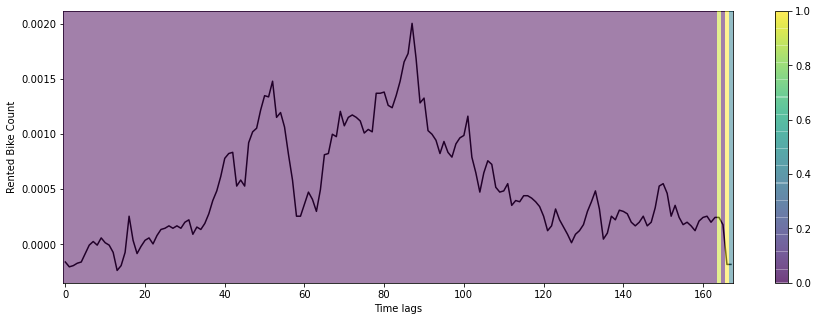

In [29]:
from scipy.ndimage import zoom
import random
import pylab

X_test=testX.copy()
id_=24*12
testX_inverse=X_test[id_][:,0]*(np.max(values)-np.min(values))+np.min(values)
testX_inverse

X_test=testX.copy()
activation = activation_grad(X_test[id_], model)
print(activation)
plt.figure(figsize=(15,5))

plt.plot(testX_inverse/100000, 'k')
#plt.plot(yhat, label='predict')
#plt.plot(testY, label='true')
plt.ylabel('Rented Bike Count'); plt.xlabel('Time lags'); #plt.title(pd.to_datetime(test_date[sequence_length+id_]))
plt.twinx()
#plt.xticks(a)
plt.imshow(np.vstack([activation]*120), alpha=0.5, cmap='viridis')
plt.axis('off'); plt.colorbar()
plt.axis('off')
#pylab.pcolor(np.vstack([activation]*120),cmap='jet',alpha=0.35)

#pylab.colorbar()

np.set_printoptions(False)

plt.savefig('C:/Users/mozzimerci/jupyter notebook/time/chan/ff/png/pm2.5_grad cam_lstm-rescnn(1).png', dpi=300)

1.0
0.0
1.0
(1, 168, 8)


<Figure size 432x1440 with 0 Axes>

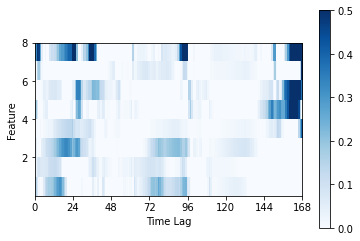

In [30]:
import matplotlib.pyplot as plt
import numpy as np

X_test=testX

grad_weight = gradient_weight(X_test[4], model)

grad_weight_abs = abs(grad_weight)

grad_weight_abs_z = (grad_weight_abs-(np.min(grad_weight_abs)))/(np.max(grad_weight_abs)-(np.min(grad_weight_abs)))

print(np.max(grad_weight_abs_z))
print(np.min(grad_weight_abs_z))
print(np.max(grad_weight_abs_z)-np.min(grad_weight_abs_z))
#grad_weight=grad_weight.reshape(48,4)

print(grad_weight.shape)
plt.figure(figsize=(6,20))

#plt.plot(X_test[8], 'k')
a=grad_weight.numpy()
a=a.reshape(168,8)
a=a.transpose()

#print(a)
fig, ax = plt.subplots(1,1)

extent = [0 , 168, 0 , 8]
y_label_list = [2,4,6,8]
x_label_list = [0,24,48,72,96,120,144,168]
ax.set_xticks([0,24,48,72,96,120,144,168])

ax.set_yticks([24,48,72,96])

ax.set_xticklabels(x_label_list)
ax.set_yticklabels(y_label_list)

ax.set_xticklabels(x_label_list)
ax.set_yticklabels(y_label_list)
ax.set_ylabel('Feature')
ax.set_xlabel('Time Lag')

plt.imshow(a,extent = [0 , 168, 0 , 96], vmin=0, vmax=0.5, cmap="Blues", interpolation='nearest')
plt.colorbar()

plt.savefig('C:/Users/mozzimerci/jupyter notebook/time/chan/ff/png/pm2.5_feature importance_lstm-rescnn(1).png', dpi=300)